## Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
### Week 3 - Complete Assignment (Part 1, 2, 3)

### Importing Libraries for Project


In [133]:
import numpy as np
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('expand_frame_repr', False)

import requests # library to handle requests
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from IPython.display import display
from IPython.core.display import HTML

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print("Library Loaded")

Library Loaded


### Part 1 -> Scrapping data from Wiki into Dataframe

In [95]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#page = urlopen(url).read().decode('utf-8')
page = requests.get(url).text
soup = BeautifulSoup(page, 'lxml')

wiki_table = soup.body.table.tbody

table_rows = wiki_table.find_all('tr')
data = []  
for tr in table_rows:
    td = tr.find_all('td')
    #row = [tr.text for tr in td]
    row = [tr.text.strip() for tr in td]
    #print(row) 
    data.append(row)     

#print(data)    
columns = ['Postcode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(data, columns=columns)
print("Count of originally scrapped Wiki Page table details ->", df.shape)
print(df.head())

Count of originally scrapped Wiki Page table details -> (289, 3)
  Postcode       Borough     Neighbourhood
0     None          None              None
1      M1A  Not assigned      Not assigned
2      M2A  Not assigned      Not assigned
3      M3A    North York         Parkwoods
4      M4A    North York  Victoria Village


### Part 1 -> Cleansing the data

In [96]:
#Removing Borough with "Not assigned" values
df['Borough'].replace('Not assigned', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)
print("Count Post Removing \"Not Assigned\" Borough ->", df.shape)

#Replacing "Not assigned" Neighbourhood with Borough value
df['Neighbourhood'].replace('Not assigned', df['Borough'], inplace=True)
print("Count Post Re-assigning \"Not Assigned\" Neighbourhood with Borough ->", df.shape)

df_cleaned = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_cleaned.columns = ['Postcode', 'Borough', 'Neighbourhood']
print("Count Post grouping by Post Code ", df_cleaned.shape)
print(df_cleaned)

Count Post Removing "Not Assigned" Borough -> (211, 3)
Count Post Re-assigning "Not Assigned" Neighbourhood with Borough -> (211, 3)
Count Post grouping by Post Code  (103, 3)
    Postcode           Borough                                      Neighbourhood
0        M1B       Scarborough                                     Rouge, Malvern
1        M1C       Scarborough             Highland Creek, Rouge Hill, Port Union
2        M1E       Scarborough                  Guildwood, Morningside, West Hill
3        M1G       Scarborough                                             Woburn
4        M1H       Scarborough                                          Cedarbrae
5        M1J       Scarborough                                Scarborough Village
6        M1K       Scarborough        East Birchmount Park, Ionview, Kennedy Park
7        M1L       Scarborough                    Clairlea, Golden Mile, Oakridge
8        M1M       Scarborough    Cliffcrest, Cliffside, Scarborough Village West
9   

### Part 1 -> Final Shape of Cleansed DF, end of Part 1

In [97]:
df_cleaned.shape

(103, 3)

### Part2 -> Getting Latitude and the Longitude coordinates of each neighborhood

In [126]:
#Get Postcode, Longitude, Latitude into DF
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.columns = ['Postcode', 'Latitude', 'Longitude']
print(df_geo.head())

  Postcode   Latitude  Longitude
0      M1B  43.806686 -79.194353
1      M1C  43.784535 -79.160497
2      M1E  43.763573 -79.188711
3      M1G  43.770992 -79.216917
4      M1H  43.773136 -79.239476


### Part 2 -> Merged Dataframe with Geo Coordinates, end of Part 2

In [127]:
#Merge the DF 
df_pos = pd.merge(df_cleaned, df_geo, on=['Postcode'], how='inner')

df_tor = df_pos[['Borough', 'Neighbourhood', 'Postcode', 'Latitude', 'Longitude']].copy()

print(df_tor.head())

       Borough                           Neighbourhood Postcode   Latitude  Longitude
0  Scarborough                          Rouge, Malvern      M1B  43.806686 -79.194353
1  Scarborough  Highland Creek, Rouge Hill, Port Union      M1C  43.784535 -79.160497
2  Scarborough       Guildwood, Morningside, West Hill      M1E  43.763573 -79.188711
3  Scarborough                                  Woburn      M1G  43.770992 -79.216917
4  Scarborough                               Cedarbrae      M1H  43.773136 -79.239476


### Part 3 -> Explore and cluster the neighborhoods in Toronto, Get Coordinates for Toronto

In [100]:
# Getting the coordinates for Toronto
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Toronto are {}, {}.'.format(latitude, longitude))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of the City of Toronto are 43.653963, -79.387207.


In [130]:
#Sample Data Anaylsis
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_tor ['Borough'].unique()),
        df_tor .shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [16]:
df2.shape

(103, 3)

### Part 3 -> Plotting the Boroughs in cluster (using K-Mean) on Toronto map, end of Part 3

In [138]:
#Plotting the Borough as clusters (using K-mean) on Toronto map 

TORONTO_COORDINATES = (latitude, longitude)
toronto_map = folium.Map(location=TORONTO_COORDINATES, zoom_start=10)
#display(toronto_map)

X = df_tor['Latitude']
Y = df_tor['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)
#print(kmeans)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow']
df_tor['Cluster'] = clusters

#print(df_tor)

for latitude, longitude, borough, cluster in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map #gitbub was not displaying map with this option, jupyter no issues

Populating the interactive namespace from numpy and matplotlib


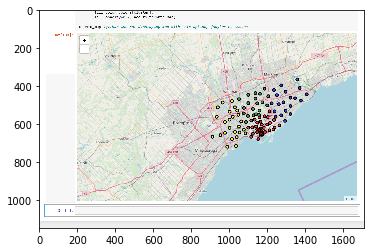

In [140]:
#Trying to somehow show the map in Github which is seen as in Jupyter
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('toronto_map.png')
imgplot = plt.imshow(img)
plt.show()